In [24]:
#Counteor for the number of errors in the grid
import os
from os.path import join
path = os.getcwd()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

parent = os.path.abspath("..")
DBS = join(parent,"results","databases")

# Change this accordingly
RESULTS_DIR = "RESULTS_DIR_PATH"
RESULTS_DB_DIR = join(RESULTS_DIR, "databases")
GRID_SNAPS_DIR = join(RESULTS_DIR, "grid_snapshots")
RESULTS_POSTPROC_DIR = join(RESULTS_DIR, "postprocessed")


In [ ]:
from pydoc import ispath
import pandas as pd
import h5py
import numpy as np

scenarios = ["EV", "EV_PV", "EV_PV_STO", "GRID_OBSV"]
counter = {}
counter_total = {}
min_v_dict={}
no_cars_list=[]
for scenario in scenarios:
    counter[scenario]=[]
    counter_total[scenario]={}
    issues_list_by_car = []
    for n_cars in range(49,300):
    # search if folder exists
        DB_NAME = join(RESULTS_DB_DIR,f"RESULTS_{scenario}_{n_cars}.hdf5")
        if os.path.isfile(DB_NAME):
            if scenario =="EV":
                no_cars_list.append(n_cars)
            data = h5py.File(DB_NAME, "r")
    
            series = {}

            # Which datarows do I want
            series["bus"] = [b for b in data["Series"].keys() if "bus" in b.lower()]
            if scenario == "GRID_OBSV":
                series["bus"] = [b for b in data["Series"].keys() if "gridnode" in b.lower()]
            results = {}
            params = {}
            output_list=[]
            column_names = series["bus"]
            par = "vm_pu"
            for column in column_names:
                output = data["Series"][column][par]
                output = np.array(output)
                output_list.append(output)
                results[column.split("-")[-1]] = np.array(output)

            df = pd.DataFrame(results)

            list_issues = []

            for idx in df.index:
                issue = 0 
                voltages = [df.at[idx,c] for c in df.columns]
                if min(voltages)<0.95:
                    issue=1
                list_issues.append(issue)

            issues_statistic=[]
            issues_count =[]
            # there are 96 values per day
            # a maximum of 96*7/10
            max_allowed = int(round(96*7/20))
            for i, issue in enumerate(list_issues):
                problem = 0

                if i<=96*7:
                    sublist = list_issues[0:i+1]
                else:
                    sublist = list_issues[i+1-96*7:i+1]
                    assert(len(sublist)==96*7)
                week_issues = sublist.count(1)
                issues_count.append(week_issues)
                if week_issues >=max_allowed:
                    problem = 1

                issues_statistic.append(problem)
            issues_statistic_count=issues_statistic.count(1)
            issues_list_by_car.append(issues_statistic_count)
            counter_total[scenario][n_cars]=issues_count


    counter[scenario]=issues_list_by_car
counter["n_cars"] = no_cars_list


counter

C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_21844\356956125.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='right', fontsize= 8)
C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_21844\356956125.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='right', fontsize= 8)
C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_21844\356956125.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='right', fontsize= 8)
C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_21844\356956125.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='right', fontsize= 8)


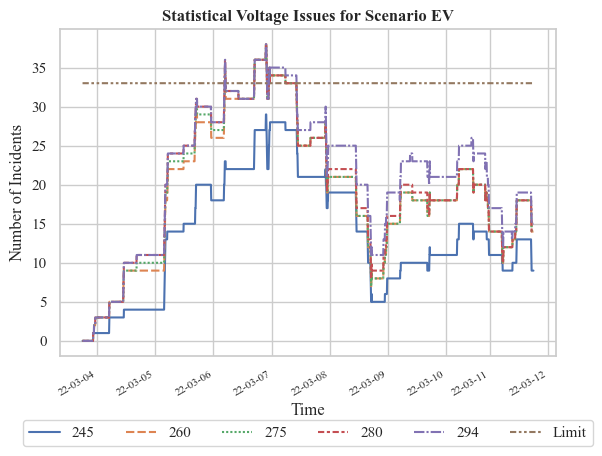

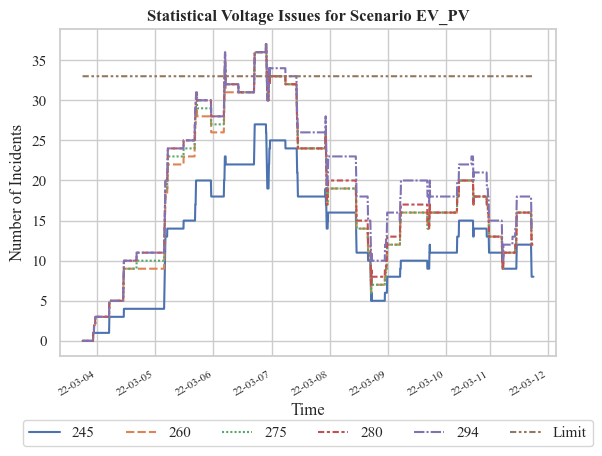

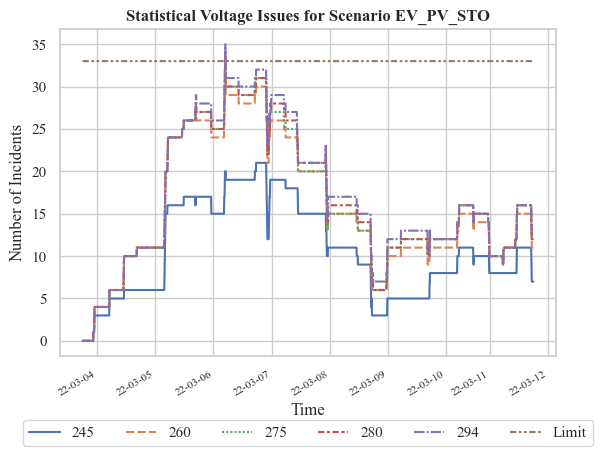

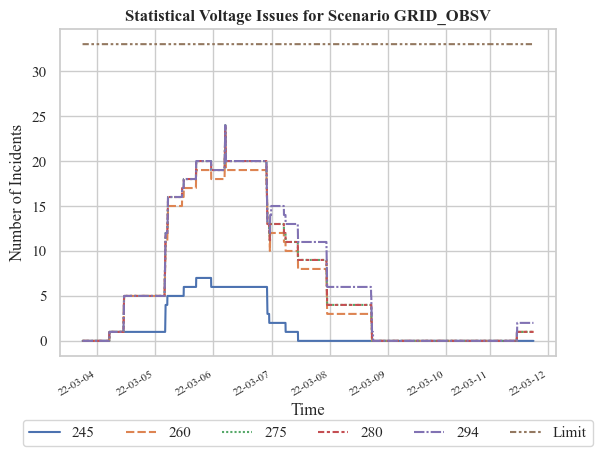

In [26]:
for scenario in scenarios:
    sns.set(font = "Times New Roman", style ="whitegrid")
    data = counter_total[scenario]
    data_plot = {}
    for key in data.keys():
        if key > 230:
            data_plot[key]= data[key]
    dti = pd.date_range(start="2022-03-04", periods=len(data[key]), freq="15T")
    data_plot["Time"] = dti
    limit = [33 for _ in data[key]]
    data_plot["Limit"]= limit

    df = pd.DataFrame.from_dict(data_plot)
    df.set_index("Time", inplace=True)
    sns.set(font = "Times New Roman", style ="whitegrid")
    from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange

    fig,ax = plt.subplots()
    sns.lineplot(data=df,ax=ax)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of Incidents")
    ax.set_title(f"Statistical Voltage Issues for Scenario {scenario}",fontweight="bold")
    x_dates = dti.strftime('%y-%m-%d').sort_values().unique()

    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right', fontsize= 8)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
            ncol=6)
    #ax.fmt_xdata = DateFormatter('%yy-% m-% d ')
    fig.autofmt_xdate()
    fig.savefig(f"figs\\timeseries_voltage_issues_{scenario}.png")


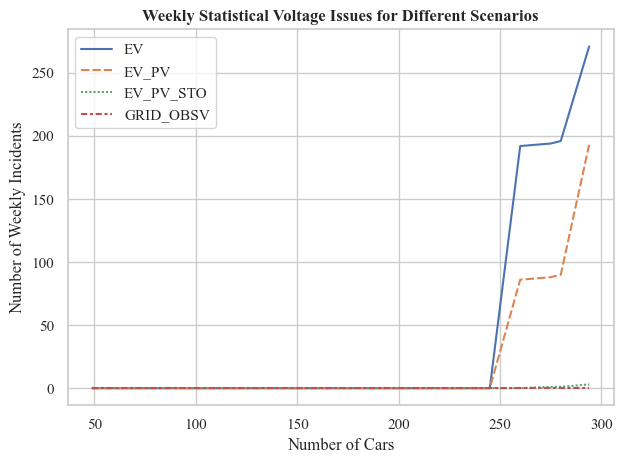

In [27]:
sns.set(font = "Times New Roman", style ="whitegrid")

counter_df = pd.DataFrame.from_dict(counter)
counter_df.set_index("n_cars", inplace=True)
fig,ax = plt.subplots()
sns.lineplot(data=counter_df,ax=ax)
ax.set_xlabel("Number of Cars")
ax.set_ylabel("Number of Weekly Incidents")
ax.set_title("Weekly Statistical Voltage Issues for Different Scenarios",fontweight="bold")

plt.tight_layout()
fig.savefig("figs\\weekly_voltage_issues_line.png")

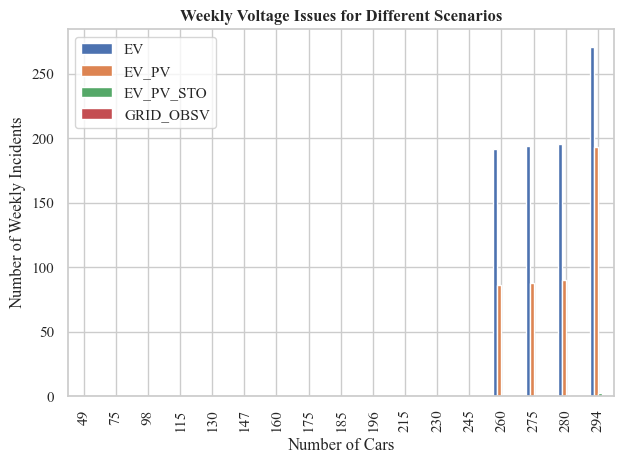

In [28]:
fig,ax = plt.subplots()
counter_df.plot.bar(ax=ax)

ax.set_xlabel("Number of Cars")
ax.set_ylabel("Number of Weekly Incidents")
ax.set_title("Weekly Voltage Issues for Different Scenarios",fontweight="bold")

plt.tight_layout()
fig.savefig("figs\\weeky_voltage_issues_bar.png")

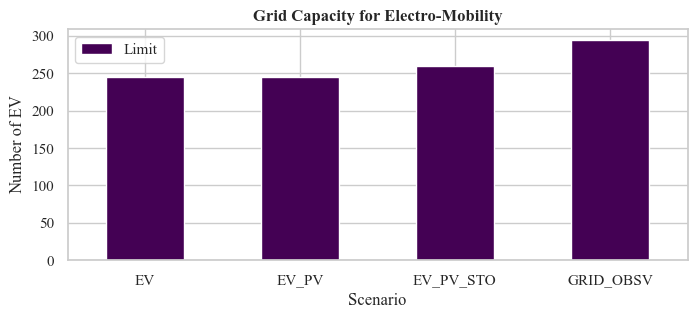

In [52]:
# Look for the limit
limits = {}
limits["Scenario"]=[]
limits["Limit"]=[]
for scenario in scenarios:
    previous_idx = None
    for idx in counter_df.index:
        if counter_df.loc[idx,scenario] == 0:
            limit = idx
    limits["Scenario"].append(scenario)
    limits["Limit"].append(limit)

df_limits = pd.DataFrame.from_dict(limits)
df_limits.set_index("Scenario", inplace=True)
fig,ax = plt.subplots(figsize=(8,3))

df_limits.plot.bar(ax=ax, colormap = "viridis")

ax.set_xlabel("Scenario")
ax.set_ylabel("Number of EV")
ax.set_title("Grid Capacity for Electro-Mobility",fontweight="bold")
plt.xticks(rotation=0)
fig.savefig("figs\\bar_limits_v1.png")



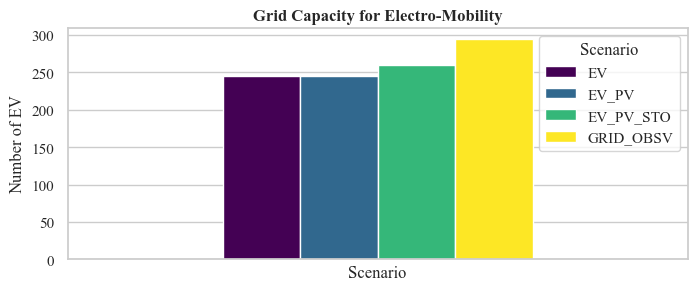

In [57]:
df_limits_t= df_limits.transpose()
fig,ax = plt.subplots(figsize=(8,3))

df_limits_t.plot.bar(ax=ax, colormap = "viridis")
plt.xticks(rotation=0)
ax.set_xlabel("Scenario")
ax.set_ylabel("Number of EV")
ax.set_title("Grid Capacity for Electro-Mobility",fontweight="bold")
plt.xticks([])

fig.savefig("figs\\bar_limits_v2.png")